In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.filters.git
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils.git
!pip install mne
# FILEID = "1pS0CSVNc6LKtZQ0cciRpw8ObyKRHnXtp"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O functions.py && rm -rf /tmp/cookies.txt
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O functions.py && rm -rf /tmp/cookies.txt 
# FILEID = "1pS0CSVNc6LKtZQ0cciRpw8ObyKRHnXtp"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O vq_function.py && rm -rf /tmp/cookies.txt 

  Cloning https://github.com/UN-GCPDS/python-gcpds.filters.git to /tmp/pip-req-build-_urrzktc
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.filters.git /tmp/pip-req-build-_urrzktc
  Created wheel for gcpds-filters: filename=gcpds_filters-0.1a0-py3-none-any.whl size=817587 sha256=51af6cb75409aff0e44d802eb9d0673a31c6c465e3dc602bf7908eb8d47abd41
  Stored in directory: /tmp/pip-ephem-wheel-cache-dcsm820d/wheels/36/7a/78/d27d0f0c7be2222e2c76dcafd6840212fbc620d24f8a7c13f0
Successfully built gcpds-filters
  Cloning https://github.com/UN-GCPDS/python-gcpds.utils.git to /tmp/pip-req-build-gea66q1i
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.utils.git /tmp/pip-req-build-gea66q1i
     |████████████████████████████████| 6.9 MB 5.4 MB/s 
  Created wheel for gcpds-utils: filename=gcpds_utils-0.1a3-py3-none-any.whl size=116894 sha256=db334954753f2d27cd775baa2c1dad6ac0f231d2d6cc80a89ba36a7bc3376cf0
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [2]:
# drive y datos
from google.colab import drive
import requests
# estructuras
import pandas as pd
# 
from ipywidgets import interact_manual
from ipywidgets import interact
# módulo para entrenamiento
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# system
import os
from time import time
# data
import pickle
import numpy as np
from numpy import angle, sin, cos, sqrt
from scipy.io import loadmat, savemat
import scipy as sp
from scipy.io import savemat
from scipy.signal import butter, lfilter, welch, hanning, filtfilt, hilbert
# figuras
import matplotlib.pyplot as plt
from gcpds.utils import loaddb
from gcpds.utils.visualizations import plot_eeg, plot_topoplot
# MNE toolbox
import mne
from mne.preprocessing import ICA
# módulo de multiproceso de las tareas.
import multiprocessing

In [4]:
import time
import vq_function as vq

def fun_entropy(data):
  entropy_ch = list()
  for ch in range(data.shape[0]):
    signal = np.squeeze(data[ch,:]).reshape(1,-1)
    r = 0.2*np.std(signal)
    E = vq.bayes_entropy2(signal,r,tau)
    entropy_ch.append(E)
  return np.asarray(entropy_ch)

## Prueba en música

sujeto:  1


NameError: ignored

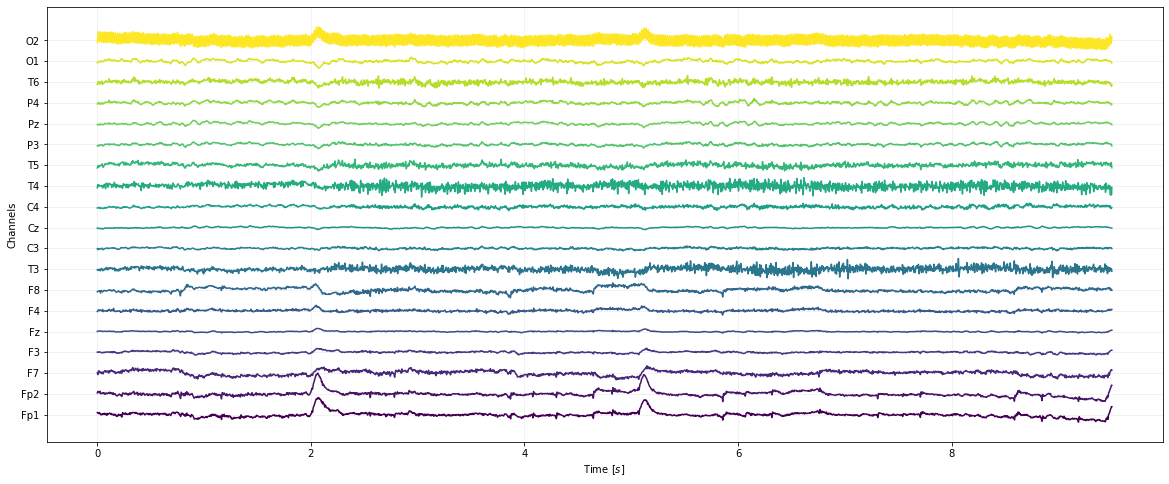

In [5]:
# Sujetos de la base de datos
Subjects = list(np.arange(1,2))
# canales de la base de datos
channels = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4',
            'T5','P3','Pz','P4','T6','O1','O2']
n_channels = len(channels)
# Frecuencia de muestreo de la base de datos.
sampling_freq  = 1000        
# ubicación de la base de datos.
load_path = '/content/drive/Shareddrives/GCPDS/databases/Auditory_processing/'
# Método utilizado para la función de ICA de MNE.
method = 'fastica'
# Número de núcleos para ell multiproceso
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# ciclo de los sujetos.
y = list()
data_ref = list()
for s in Subjects:
  # carga de la información del sujetos.
  S_ERP = loadmat(load_path + f"P"+str(s)+"_BCMI_frontHN_2017.mat")
  print('sujeto: ', s)
  data = S_ERP['music'][0][0][0]
  data = np.transpose(data, (2,1,0)) # transponer en trials x canales x tiempo
  data_target = data

  # structure mne datos en (trials,canales,tiempo)
  ch_types = ['eeg']*n_channels
  info = mne.create_info(channels, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1005')
  raw = mne.EpochsArray(data_target, info)

  # filtro la señal de 0.5 - 50 Hz.
  raw.filter(0.5,100)

  # señal sin quitar los artefactos.
  plt.figure(figsize=(20,8))
  plot_eeg(raw.get_data()[0,:,:],channels,sampling_freq)

  # Repairing artifacts with ICA
  # ica.plot_sources(raw, show_scrollbars=False)
  ica = ICA(n_components=n_channels, method=method, max_iter='auto', random_state=0)
  ica.fit(raw)
  componentes = ica.get_sources(raw).get_data()
  
  # señal sin quitar los artefactos.
  # plt.figure(figsize=(20,8))
  # plot_eeg(componentes[0,:,:],channels,sampling_freq)
  
  # Parametros para el análisis de la entropia.
  tau     = 10              # 20   30 
  window  = 1*sampling_freq # 3,   3   segundo de la ventana.
  step    = window*0.5      # 50%, 80% de traslape.
  windows = list(np.arange(0,componentes.shape[2]-window,step))

  # start_time = time.time()
  # entropy_tr = list()
  # for tr in range(data_target.shape[0]):
  #   data = list()
  #   for time_ in range(len(windows)):
  #     signal = np.squeeze(raw.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
  #     data.append(signal)
  #   # estimación de la entropía de la señal.
  #   entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  # entropy_raw = np.asarray(entropy_tr)
  # print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  # # ica.plot_sources(mne.io.RawArray(raw.get_data()[0], info))
  
  # start_time = time.time()
  # entropy_tr = list()
  # for tr in range(data_target.shape[0]):
  #   data = list()
  #   for time_ in range(len(windows)):
  #     signal = np.squeeze(componentes[tr,:,int(windows[time_]):int(windows[time_]+window)])
  #     data.append(signal)
  #   # estimación de la entropía de las componentes.
  #   entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  # entropy_com = np.asarray(entropy_tr)
  # print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  
  raw2 = raw.copy()
  # comp_ = []
  # for tr in range(entropy_com.shape[0]):
  #   datos_ = np.max(entropy_com[tr,:,:],axis=0)-np.min(entropy_com[0,:,:],axis=0)
  #   datos_f = np.asarray([round(a,1) for a in datos_])
  #   comp_.append(np.where((datos_f>0)==True)[0])
  # pos = list(np.unique(np.concatenate(comp_)))
  ica.exclude = [0,1]          # indices chosen based on various plots above sujeto 2.
  ica.apply(raw2)
  
  # # figura señal quitando artefactos
  # plt.figure(figsize=(20,8))
  # plot_eeg(raw2.get_data()[0,:,:],channels,sampling_freq)

  # start_time = time.time()
  # entropy_tr = list()
  # for tr in range(data_target.shape[0]):
  #   data = list()
  #   for time_ in range(len(windows)):
  #     signal = np.squeeze(raw2.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
  #     data.append(signal)
  #   # estimación de la entropía de la señal quitando artefactos.
  #   entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  # entropy_ica = np.asarray(entropy_tr)
  # print('Tiempo de la entropia de la señal {tim}'.format(tim=(time.time()-start_time)))

  # # CAR common average reference
  # # En la señal.
  rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ref_channels='average',projection=True,verbose=0)
  # data_ref.append(rereferenced_raw.get_data())
  data_ref = rereferenced_raw.get_data()
  # # En la señal reconstruida.
  rereferenced_raw_ica, ref_data = mne.set_eeg_reference(raw2, ref_channels='average',projection=True,verbose=0)
  data_ref_ica.append(rereferenced_raw.get_data())
  # data_ref_ica = rereferenced_raw_ica.get_data()
  # savemat(load_path+f'Resultado_music_Sujeto'+str(s)+'.mat',{'X_ica':raw2.get_data(),'X_raw':raw.get_data(),'ref_raw':data_ref,
  #           'ref_ica':data_ref_ica,'H_raw':entropy_raw,'H_com':entropy_com,'H_ica':entropy_ica})

In [ ]:
raw2 = raw.copy()
ica.exclude = [0,1]          # indices chosen based on various plots above sujeto 2.
ica.apply(raw2)
  

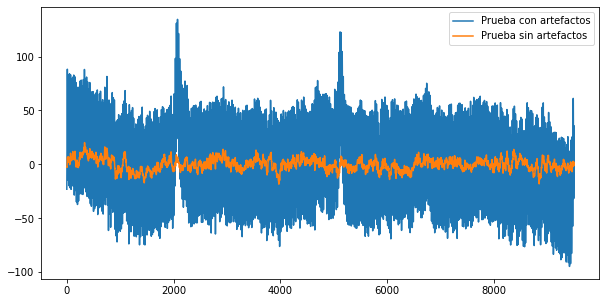

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(raw.get_data()[0,18,:],label='Prueba con artefactos')
plt.plot(raw2.get_data()[0,18,:],label='Prueba sin artefactos')
plt.legend()

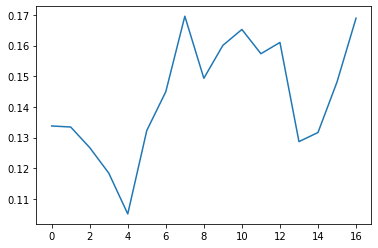

In [ ]:
plt.plot(np.max(entropy_com[0,:,:],axis=1)-abs(np.min(entropy_com[0,:,:],axis=1)))

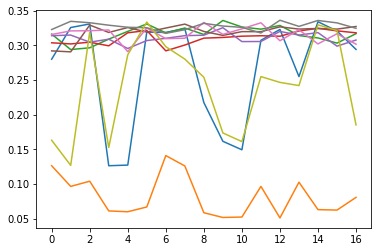

In [ ]:
plt.plot(entropy_com[0,:,0:9])

In [ ]:
comp_ = []
for tr in range(entropy_com.shape[0]):
  datos_ = np.max(entropy_com[tr,:,:],axis=0)-np.min(entropy_com[0,:,:],axis=0)
  datos_f = np.asarray([round(a,1) for a in datos_])
  comp_.append(np.where((datos_f>0)==True)[0])
list(np.unique(np.concatenate(comp_)))

[0, 1, 8]

In [ ]:
np.where((datos_f>0)==True)[0]

array([0, 1, 8])

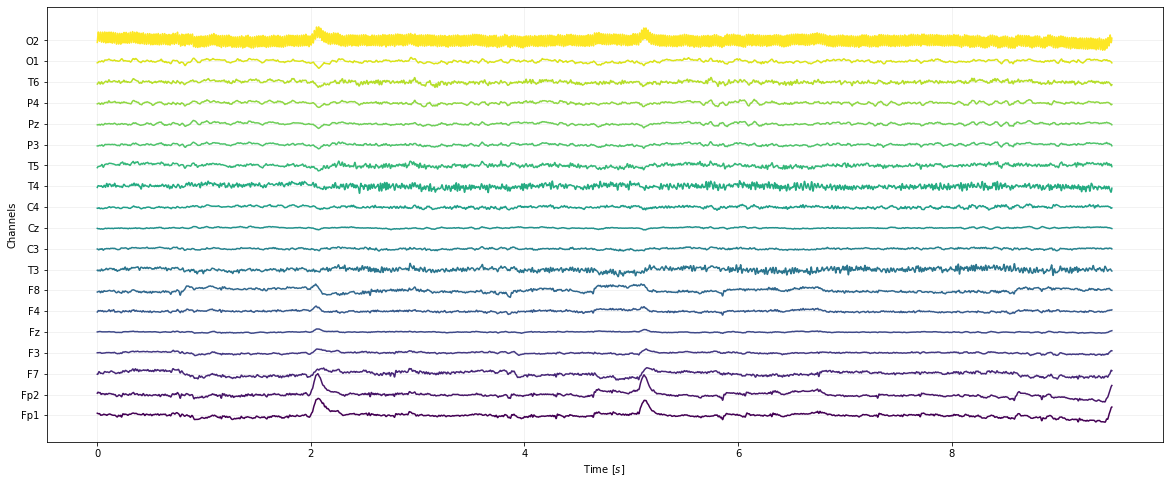

In [ ]:
subs = [1]
for s in subs:
  
  # Cargar los datos almacenados de la entropia.
  datos = loadmat(load_path+f'Resultado2_music_Sujeto'+str(s)+'.mat')
  X_raw = datos['X_raw']
  X_ica = datos['X_ica']
  plt.figure(figsize=(20,8))
  plot_eeg(X_raw[0,:,:],channels,sampling_freq)
  # plt.figure(figsize=(20,8))
  # plot_eeg(X_ica[0,:,:],channels,sampling_freq)

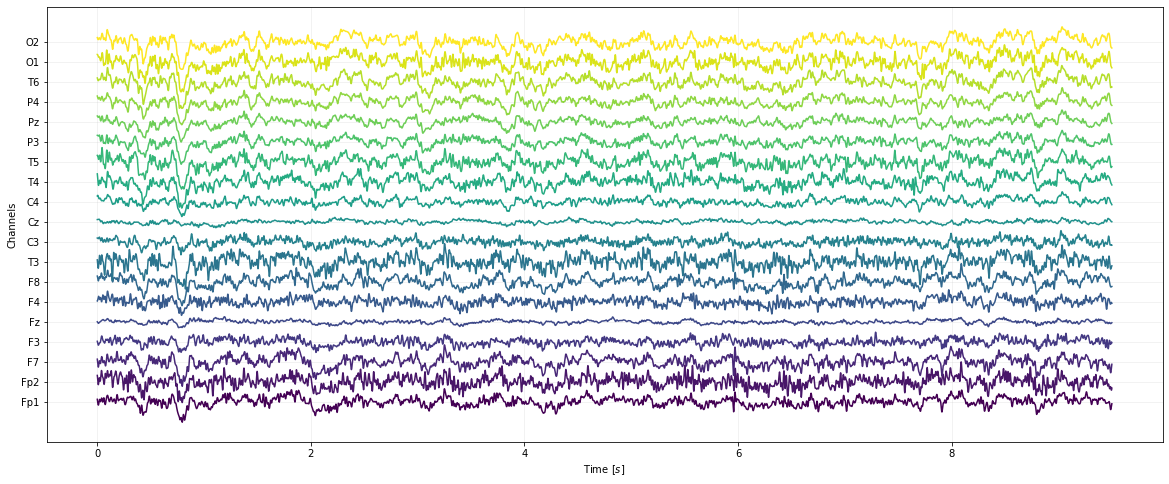

In [ ]:
subs = [7]
for s in subs:
  
  # Cargar los datos almacenados de la entropia.
  datos = loadmat(load_path+f'Resultado2_music_Sujeto'+str(s)+'.mat')
  X_raw = datos['X_raw']
  X_ica = datos['X_ica']
  # plt.figure(figsize=(20,8))
  # plot_eeg(X_raw[0,:,:],channels,sampling_freq)
  plt.figure(figsize=(20,8))
  plot_eeg(X_ica[0,:,:],channels,sampling_freq)

## Prueba en resting-state

sujeto:  1
Tiempo de la entropia de componentes 38.80249762535095


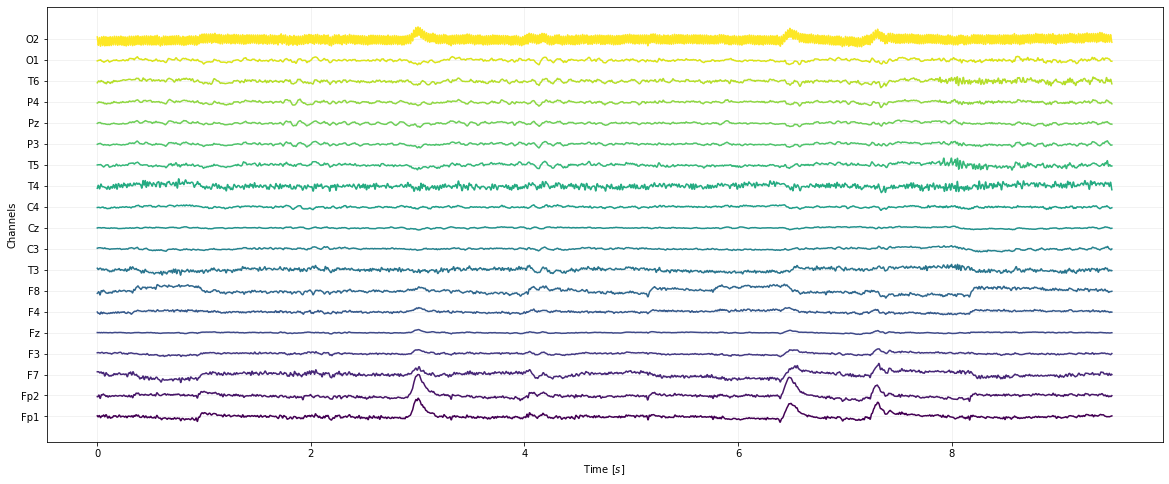

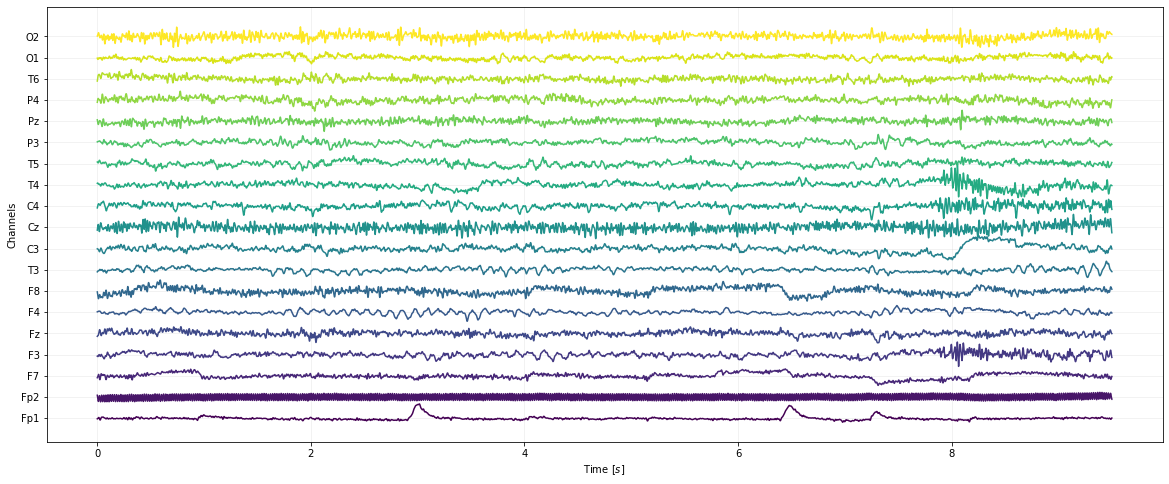

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


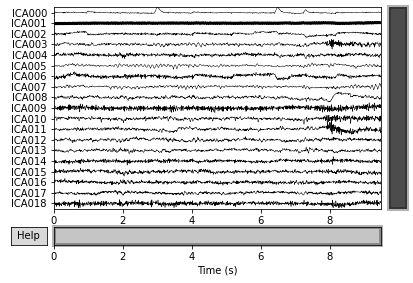

Tiempo de la entropia de componentes 39.88744831085205
Tiempo de la entropia de la señal 40.55721688270569


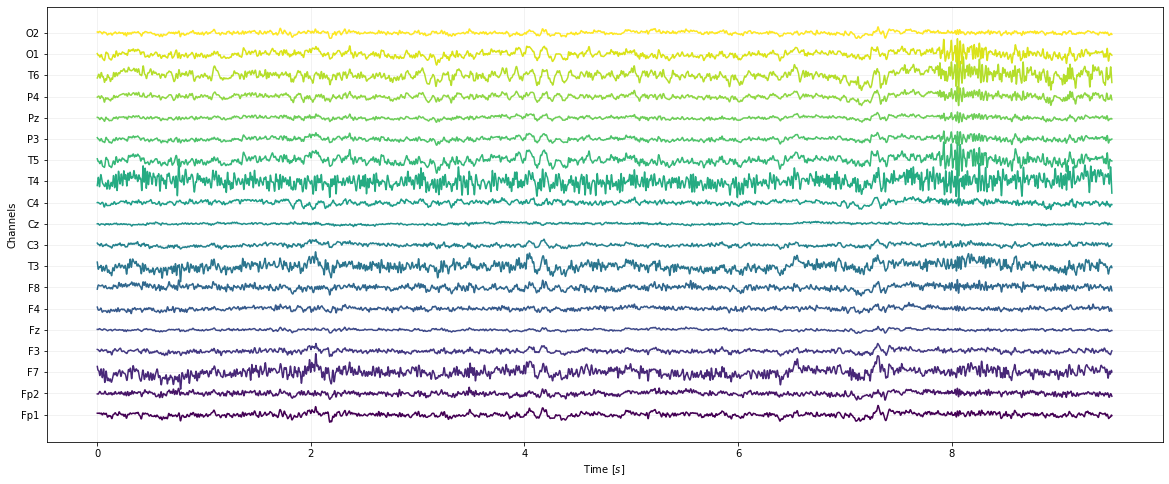

In [ ]:
# Sujetos de la base de datos
Subjects   = list(np.arange(1,2))
# canales de la base de datos
channels   = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4',
            'T5','P3','Pz','P4','T6','O1','O2']
n_channels = len(channels)
# Frecuencia de muestreo de la base de datos.
sampling_freq  = 1000
# Número de trials para resting
N_tr   = 20
# ubicación de la base de datos.
load_path = '/content/drive/Shareddrives/GCPDS/databases/Auditory_processing/'
# Método utilizado para la función de ICA de MNE.
method = 'fastica'
# Número de núcleos para ell multiproceso
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# ciclo de los sujetos.
for s in Subjects:
  # carga de la información del sujetos.
  S_ERP = loadmat(load_path + f"P"+str(s)+"_BCMI_frontHN_2017.mat")
  print('sujeto: ', s)
  data = S_ERP['base']
  data = np.transpose(data, (1,0)) # transponer en canales x tiempo
  data = data[:n_channels,10*sampling_freq:-10*sampling_freq]
  data_target = np.zeros((N_tr,data.shape[0],9500))
  step = 9.5*sampling_freq
  windows = list(np.arange(0,data.shape[1],step))
  for tr in range(N_tr):
    data_target[tr,:,:] = data[:,int(windows[tr]):int(windows[tr]+step)]

  # structure mne datos en (trials,canales,tiempo)
  ch_types = ['eeg']*n_channels
  info = mne.create_info(channels, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1005')
  raw = mne.EpochsArray(data_target, info)

  # filtro la señal de 0.5 - 50 Hz.
  raw.filter(0.5,50)

  # señal sin quitar los artefactos.
  plt.figure(figsize=(20,8))
  plot_eeg(raw.get_data()[0,:,:],channels,sampling_freq)

  # Repairing artifacts with ICA
  # ica.plot_sources(raw, show_scrollbars=False)
  ica = ICA(n_components=n_channels, method=method, max_iter='auto', random_state=0)
  ica.fit(raw)
  componentes = ica.get_sources(raw).get_data()
  
  # señal sin quitar los artefactos.
  plt.figure(figsize=(20,8))
  plot_eeg(componentes[0,:,:],channels,sampling_freq)
  
  # Parametros para el análisis de la entropia.
  tau     = 10              # 20   30 
  window  = 1*sampling_freq # 3,   3   segundo de la ventana.
  step    = window*0.5      # 50%, 80% de traslape.
  windows = list(np.arange(0,componentes.shape[2]-window,step))

  start_time = time.time()
  entropy_tr = list()
  for tr in range(data_target.shape[0]):
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(raw.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    # estimación de la entropía de la señal.
    entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  entropy_raw = np.asarray(entropy_tr)
  print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  
  ica.plot_sources(mne.io.RawArray(raw.get_data()[0], info))
  
  start_time = time.time()
  entropy_tr = list()
  for tr in range(data_target.shape[0]):
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(componentes[tr,:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    # estimación de la entropía de las componentes.
    entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  entropy_com = np.asarray(entropy_tr)
  print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  
  raw2 = raw.copy()
  comp_ = []
  for tr in range(entropy_com.shape[0]):
    datos_ = np.max(entropy_com[tr,:,:],axis=0)-np.min(entropy_com[0,:,:],axis=0)
    datos_f = np.asarray([round(a,1) for a in datos_])
    comp_.append(np.where((datos_f>0)==True)[0])
  pos = list(np.unique(np.concatenate(comp_)))
  ica.exclude = pos          # indices chosen based on various plots above sujeto 2.
  ica.apply(raw2)
  
  # # figura señal quitando artefactos
  plt.figure(figsize=(20,8))
  plot_eeg(raw2.get_data()[0,:,:],channels,sampling_freq)

  start_time = time.time()
  entropy_tr = list()
  for tr in range(data_target.shape[0]):
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(raw2.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    # estimación de la entropía de la señal quitando artefactos.
    entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  entropy_ica = np.asarray(entropy_tr)
  print('Tiempo de la entropia de la señal {tim}'.format(tim=(time.time()-start_time)))

  # CAR common average reference
  # En la señal.
  # rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ref_channels='average',projection=True,verbose=0)
  # # data_ref.append(rereferenced_raw.get_data())
  # data_ref = rereferenced_raw.get_data()
  # # En la señal reconstruida.
  # rereferenced_raw_ica, ref_data = mne.set_eeg_reference(raw2, ref_channels='average',projection=True,verbose=0)
  # # data_ref_ica.append(rereferenced_raw.get_data())
  # data_ref_ica = rereferenced_raw.get_data()
  # savemat(load_path+f'Resultado_rest_Sujeto'+str(s)+'.mat',{'X_ica':raw2.get_data(),'X_raw':raw.get_data(),'ref_raw':data_ref,
  #           'ref_ica':data_ref_ica,'H_raw':entropy_raw,'H_com':entropy_com,'H_ica':entropy_ica})

In [ ]:
step

# prueba music y resting

In [ ]:
datos_f

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0. , 0. , 0.1,
       0. , 0. , 0. , 0. , 0.1, 0.1])

In [ ]:
import matplotlib.pyplot as plt
import mne
# Sujetos de la base de datos
Subjects = list(np.arange(1,22))
# canales de la base de datos
channels = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4',
            'T5','P3','Pz','P4','T6','O1','O2']
n_channels = len(channels)
# Frecuencia de muestreo de la base de datos.
sampling_freq  = 1000
# Número de trials en resting
N_tr = 20
# ubicación de la base de datos.
load_path = '/content/drive/Shareddrives/GCPDS/databases/Auditory_processing/'
# Método utilizado para la función de ICA de MNE.
method = 'fastica'
# Número de núcleos para ell multiproceso
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# ciclo de los sujetos.
y = list()
data_ref = list()
for s in Subjects:
  # carga de la información del sujetos.
  S_ERP = loadmat(load_path + f"P"+str(s)+"_BCMI_frontHN_2017.mat")
  print('sujeto: ', s)
  data_m = S_ERP['music'][0][0][0]
  data_m = np.transpose(data_m, (2,1,0)) # transponer en trials x canales x tiempo
  data_target_m = data_m
  data_r = S_ERP['base']
  data_r = np.transpose(data_r, (1,0)) # transponer en canales x tiempo
  data_r = data_r[:n_channels,10*sampling_freq:-10*sampling_freq]
  data_target_r = np.zeros((N_tr,data_r.shape[0],9500))
  step = 9.5*sampling_freq
  windows = list(np.arange(0,data_r.shape[1],step))
  for tr in range(N_tr):
    data_target_r[tr,:,:] = data_r[:,int(windows[tr]):int(windows[tr]+step)]
  data_target = np.concatenate([data_target_m,data_target_r],axis=0)

  # structure mne datos en (trials,canales,tiempo)
  ch_types = ['eeg']*n_channels
  info = mne.create_info(channels, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1005')
  raw = mne.EpochsArray(data_target, info)

  # señal sin quitar los artefactos.
  plt.figure(figsize=(20,8))
  plot_eeg(data_target_m[0,:,:],channels,sampling_freq)
  plt.title('Señal trial 1 de música-sin filtrar')

  # filtro la señal de 0.5 - 50 Hz.
  raw.filter(0.5,100)

  plt.figure(figsize=(20,8))
  plot_eeg(raw.get_data()[0,:,:],channels,sampling_freq)
  plt.title('Señal trial 1 de música-filtrada de 0.5 a 100 Hz')

  # plt.figure(figsize=(20,8))
  # plot_eeg(data_target_r[0,:,:],channels,sampling_freq)
  # plt.title('Señal trial 1 de resting-sin filtrar')


  # plt.figure(figsize=(20,8))
  # plot_eeg(raw.get_data()[13,:,:],channels,sampling_freq)
  # plt.title('Señal trial 1 de música-filtrada de 0.5 a 100 Hz')

  # Repairing artifacts with ICA
  # ica.plot_sources(raw, show_scrollbars=False)
  ica = ICA(n_components=n_channels, method=method, max_iter='auto', random_state=0)
  ica.fit(raw)
  componentes = ica.get_sources(raw).get_data()
  
  # # señal sin quitar los artefactos.
  # plt.figure(figsize=(20,8))
  # plot_eeg(componentes[0,:,:],channels,sampling_freq)
  
  # Parametros para el análisis de la entropia.
  tau     = 10              # 20   30 
  window  = 1*sampling_freq # 3,   3   segundo de la ventana.
  step    = window*0.5      # 50%, 80% de traslape.
  windows = list(np.arange(0,componentes.shape[2]-window,step))

  start_time = time.time()
  entropy_tr = list()
  for tr in range(data_target.shape[0]):
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(raw.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    # estimación de la entropía de la señal.
    entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  entropy_raw = np.asarray(entropy_tr)
  print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  
  # ica.plot_sources(mne.io.RawArray(raw.get_data()[0], info))
  
  start_time = time.time()
  entropy_tr = list()
  for tr in range(data_target.shape[0]):
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(componentes[tr,:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    # estimación de la entropía de las componentes.
    entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  entropy_com = np.asarray(entropy_tr)
  print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  
  raw2 = raw.copy()
  # comp_ = []
  # for tr in range(entropy_com.shape[0]):
  #   datos_ = np.max(entropy_com[tr,:,:],axis=0)-np.min(entropy_com[0,:,:],axis=0)
  #   datos_f = np.asarray([round(a,1) for a in datos_])
  #   comp_.append(np.where((datos_f>0)==True)[0])
  # pos = list(np.unique(np.concatenate(comp_)))
  # pos.extend([0,1])
  ica.exclude = [0]          # indices chosen based on various plots above sujeto 2.
  ica.apply(raw2)
  
  # figura señal quitando artefactos
  plt.figure(figsize=(20,8))
  plot_eeg(raw2.get_data()[0,:,:],channels,sampling_freq)

  start_time = time.time()
  entropy_tr = list()
  for tr in range(data_target.shape[0]):
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(raw2.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    # estimación de la entropía de la señal quitando artefactos.
    entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  entropy_ica = np.asarray(entropy_tr)
  print('Tiempo de la entropia de la señal {tim}'.format(tim=(time.time()-start_time)))

  # CAR common average reference
  # En la señal.
  rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ref_channels='average',projection=True,verbose=0)
  # data_ref.append(rereferenced_raw.get_data())
  data_ref = rereferenced_raw.get_data()
  # En la señal reconstruida.
  rereferenced_raw_ica, ref_data = mne.set_eeg_reference(raw2, ref_channels='average',projection=True,verbose=0)
  # data_ref_ica.append(rereferenced_raw.get_data())
  data_ref_ica = rereferenced_raw_ica.get_data()
  savemat(load_path+f'Resultado2_music_rest_Sujeto'+str(s)+'.mat',{'X_ica':raw2.get_data(),'X_raw':raw.get_data(),'ref_raw':data_ref,
            'ref_ica':data_ref_ica,'H_raw':entropy_raw,'H_com':entropy_com,'H_ica':entropy_ica})

Output hidden; open in https://colab.research.google.com to view.

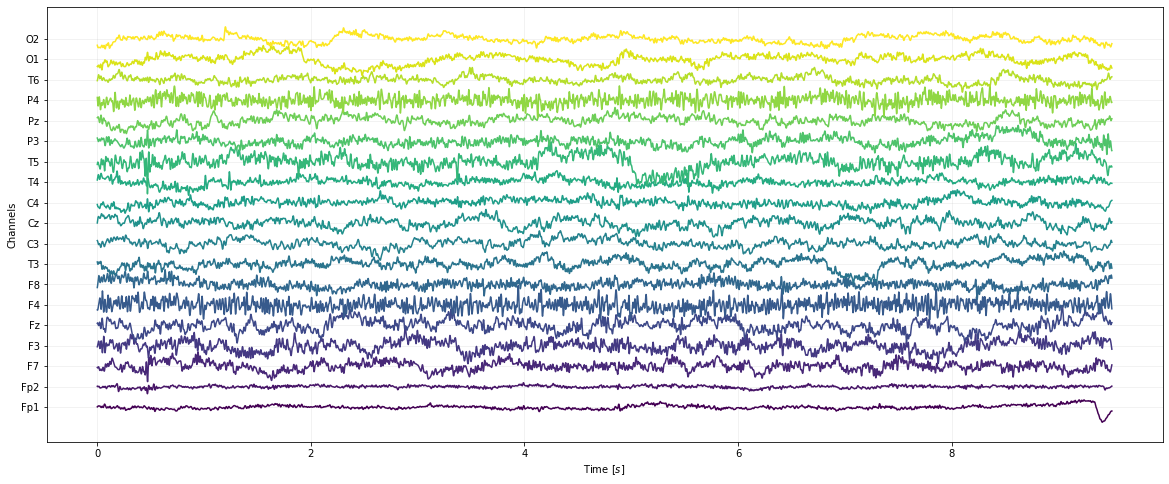

In [ ]:
# señal sin quitar los artefactos.
plt.figure(figsize=(20,8))
plot_eeg(componentes[0,:,:],channels,sampling_freq)

In [ ]:
np.concatenate([data_target_m,data_target_r],axis=0).shape

(32, 19, 9500)

In [ ]:
# Sujetos de la base de datos
# Subjects = list(np.arange(1,22))
# canales de la base de datos
channels = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4',
            'T5','P3','Pz','P4','T6','O1','O2']
n_channels = len(channels)
# Frecuencia de muestreo de la base de datos.
sampling_freq  = 1000        
# ubicación de la base de datos.
load_path = '/content/drive/Shareddrives/GCPDS/databases/Auditory_processing/'
# Método utilizado para la función de ICA de MNE.
method = 'fastica'
# Número de núcleos para ell multiproceso
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# ciclo de los sujetos.
y = list()
data_ref = list()
for s in [1,7]:#Subjects:
  # carga de la información del sujetos.
  S_ERP = loadmat(load_path + f"P"+str(s)+"_BCMI_frontHN_2017.mat")
  print('sujeto: ', s)
  data = S_ERP['music'][0][0][0]
  data = np.transpose(data, (2,1,0)) # transponer en trials x canales x tiempo
  data_target = data

  # structure mne datos en (trials,canales,tiempo)
  ch_types = ['eeg']*n_channels
  info = mne.create_info(channels, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1005')
  raw = mne.EpochsArray(data_target, info)

  # filtro la señal de 0.5 - 50 Hz.
  raw.filter(0.5,50)

  # Repairing artifacts with ICA
  # ica.plot_sources(raw, show_scrollbars=False)
  ica = ICA(n_components=n_channels, method=method, max_iter='auto', random_state=0)
  ica.fit(raw)
  componentes = ica.get_sources(raw).get_data()
  
  # Parametros para el análisis de la entropia.
  tau     = 7               # 20   30 
  window  = 2*sampling_freq # 3,   3   segundo de la ventana.
  step    = window*0.5      # 50%, 80% de traslape.
  windows = list(np.arange(0,componentes.shape[2]-window,step))

  start_time = time.time()
  entropy_tr = list()
  for tr in range(data_target.shape[0]):
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(raw.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    # estimación de la entropía de la señal.
    entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  entropy_raw = np.asarray(entropy_tr)
  print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  
  start_time = time.time()
  entropy_tr = list()
  for tr in range(data_target.shape[0]):
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(componentes[tr,:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    # estimación de la entropía de las componentes.
    entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  entropy_com = np.mean(np.asarray(entropy_tr),axis=0)
  print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  
  raw2 = raw.copy()
  pos = []                   # Indices de las componentes.
  pos.append(np.argmax(np.max(entropy_com,axis=0)-abs(np.min(entropy_com,axis=0))))
  n = np.max(entropy_com,axis=0)-abs(np.min(entropy_com,axis=0))
  pos.append(n.argsort()[-2])
  ica.exclude = pos          # indices chosen based on various plots above sujeto 2.
  ica.apply(raw2)
  
  start_time = time.time()
  entropy_tr = list()
  for tr in range(data_target.shape[0]):
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(raw2.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    # estimación de la entropía de la señal quitando artefactos.
    entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  entropy_ica = np.asarray(entropy_tr)
  print('Tiempo de la entropia de la señal {tim}'.format(tim=(time.time()-start_time)))

  # CAR common average reference
  # En la señal.
  rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ref_channels='average',projection=True,verbose=0)
  # data_ref.append(rereferenced_raw.get_data())
  data_ref = rereferenced_raw.get_data()
  # En la señal reconstruida.
  rereferenced_raw_ica, ref_data = mne.set_eeg_reference(raw2, ref_channels='average',projection=True,verbose=0)
  # data_ref_ica.append(rereferenced_raw.get_data())
  data_ref_ica = rereferenced_raw_ica.get_data()
  savemat(load_path+f'Resultado2_music_Sujeto'+str(s)+'.mat',{'X_ica':raw2.get_data(),'X_raw':raw.get_data(),'ref_raw':data_ref,
            'ref_ica':data_ref_ica,'H_raw':entropy_raw,'H_com':entropy_com,'H_ica':entropy_ica})

sujeto:  1
Tiempo de la entropia de componentes 41.714996099472046
Tiempo de la entropia de componentes 45.472445249557495
Tiempo de la entropia de la señal 42.726064682006836
sujeto:  7
Tiempo de la entropia de componentes 43.18988013267517
Tiempo de la entropia de componentes 47.86094784736633
Tiempo de la entropia de la señal 43.58521270751953


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


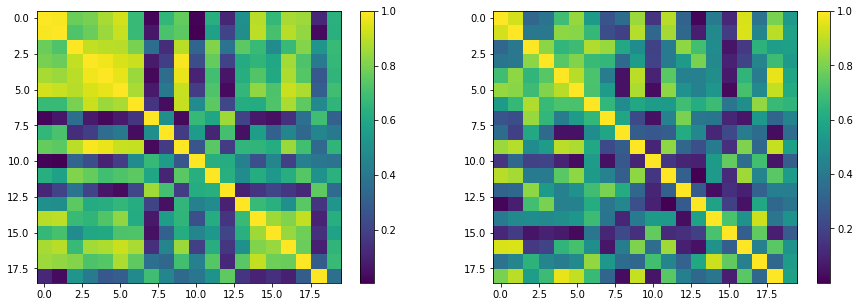

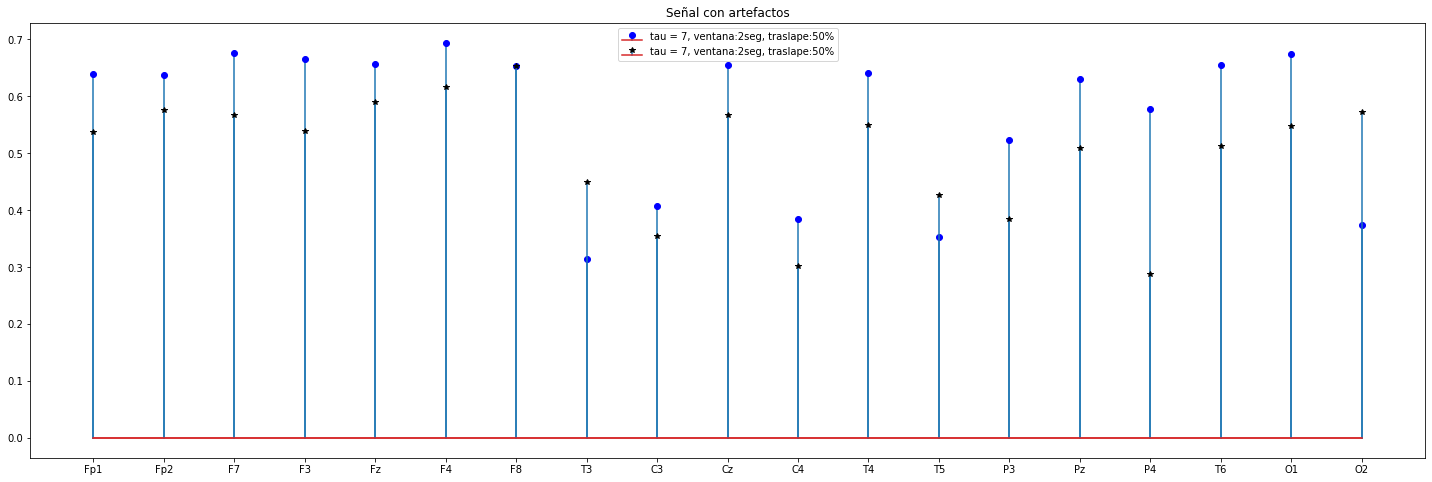

In [ ]:
from scipy.stats import pearsonr

matr_ = list()
matr_a= list()
subs = [1]
channels = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4',
            'T5','P3','Pz','P4','T6','O1','O2']
for s in subs:
  # Cargar los datos almacenados de la entropia.
  datos = loadmat(load_path+f'Resultado2_music_Sujeto'+str(s)+'.mat')
  entropy_raw = np.mean(datos['H_raw'],axis=0)
  entropy_ica = np.mean(datos['H_ica'],axis=0)
  # figura de la correlación de la entropia de la señal
  matr = np.zeros((entropy_raw.shape[1],entropy_raw.shape[1]+1))
  entropy_raw[np.isnan(entropy_raw)]=np.min(entropy_raw)

  for ch1 in range(entropy_raw.shape[1]):
    for ch2 in range(entropy_raw.shape[1]):
      # if ch1 != ch2:
      entropy_raw[np.isnan(entropy_raw[:,ch1]),ch1] = 0
      entropy_raw[np.isnan(entropy_raw[:,ch2]),ch2] = 0
      matr[ch1,ch2] = np.abs(pearsonr(entropy_raw[:,ch1],entropy_raw[:,ch2])[0])
      matr[ch2,ch1] = np.abs(pearsonr(entropy_raw[:,ch1],entropy_raw[:,ch2])[0])   
  matr[:,19] = np.sum(matr[:,:19],axis=1)/19
  matr_.append(np.sum(matr[:,:19],axis=1)/19)
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.imshow(matr,aspect='auto')
  plt.colorbar()
  # matr[:,19] = (np.mean(matr[:,:19],axis=1)-(np.std(matr[:,:19],axis=1)/2))

  # figura de la correlación de la entropia de la señal
  matr = np.zeros((entropy_ica.shape[1],entropy_ica.shape[1]+1))
  entropy_ica[np.isnan(entropy_ica)]=np.min(entropy_ica)

  for ch1 in range(entropy_ica.shape[1]):
    for ch2 in range(entropy_ica.shape[1]):      
      # if ch1 != ch2:
      entropy_ica[np.isnan(entropy_ica[:,ch1]),ch1] = 0
      entropy_ica[np.isnan(entropy_ica[:,ch2]),ch2] = 0
      matr[ch1,ch2] = np.abs(pearsonr(entropy_ica[:,ch1],entropy_ica[:,ch2])[0])
      matr[ch2,ch1] = np.abs(pearsonr(entropy_ica[:,ch1],entropy_ica[:,ch2])[0])   
  matr[:,19] = np.sum(matr[:,:19],axis=1)/19
  matr_.append(np.sum(matr[:,:19],axis=1)/19)

  # matr[:,19] = (np.mean(matr[:,:19],axis=1)-(np.std(matr[:,:19],axis=1)/2))
  plt.subplot(1,2,2)
  plt.imshow(matr,aspect='auto')
  plt.colorbar()
  
  # plt.subplot(1,2,1)  
  plt.figure(figsize=(25,8))
  plt.stem(matr_[0],markerfmt='ob',label='tau = 7, ventana:2seg, traslape:50%')
  plt.stem(matr_[1],markerfmt='*k',label='tau = 7, ventana:2seg, traslape:50%')
  plt.xticks(np.arange(len(channels)),channels)
  plt.title('Señal con artefactos')

plt.legend()
plt.show()

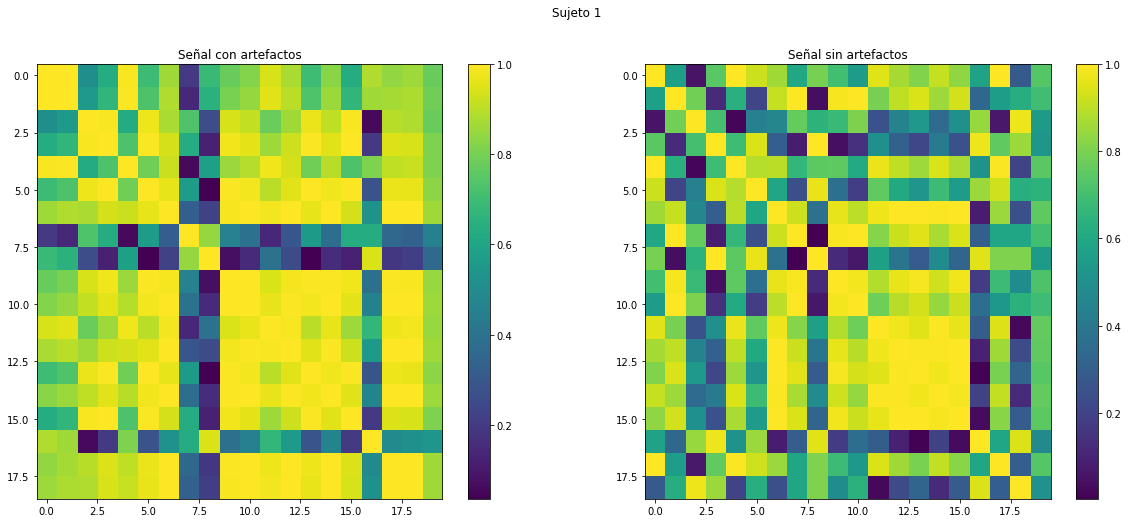

In [ ]:
from scipy.stats import pearsonr

matr_ = list()
matr_a= list()
subs = [1]
for s in subs:
  plt.figure(figsize=(20,8))
  # Cargar los datos almacenados de la entropia.
  datos = loadmat(load_path+f'Resultado2_music_Sujeto'+str(s)+'.mat')
  entropy_raw = np.mean(datos['H_raw'],axis=0)
  entropy_ica = np.mean(datos['H_ica'],axis=0)
  
  # figura de la correlación de la entropia de la señal
  matr = np.zeros((entropy_raw.shape[1],entropy_raw.shape[1]+1))
  entropy_raw[np.isnan(entropy_raw)]=np.min(entropy_raw)

  for ch1 in range(entropy_raw.shape[1]):
    for ch2 in range(entropy_raw.shape[1]):
      # if ch1 != ch2:
      entropy_raw[np.isnan(entropy_raw[:,ch1]),ch1] = 0
      entropy_raw[np.isnan(entropy_raw[:,ch2]),ch2] = 0
          
      matr[ch1,ch2] = np.abs(pearsonr(entropy_raw[:,ch1],entropy_raw[:,ch2])[0])
      matr[ch2,ch1] = np.abs(pearsonr(entropy_raw[:,ch1],entropy_raw[:,ch2])[0])
   
  matr[:,19] = np.sum(matr[:,:19],axis=1)/19
  matr_.append(np.sum(matr[:,:19],axis=1)/19)
  # matr[:,19] = (np.mean(matr[:,:19],axis=1)-(np.std(matr[:,:19],axis=1)/2))
  plt.subplot(1,2,1)
  plt.imshow(matr,aspect='auto')
  plt.colorbar()
  plt.title('Señal con artefactos')

  # figura de la correlación de la entropia de la señal filtrada.
  matr = np.zeros((entropy_ica.shape[1],entropy_ica.shape[1]+1))
  entropy_ica[np.isnan(entropy_ica)]=np.min(entropy_ica)
  for ch1 in range(entropy_ica.shape[1]):
    for ch2 in range(entropy_ica.shape[1]):
      # if ch1 != ch2:
      entropy_ica[np.isnan(entropy_ica[:,ch1]),ch1] = 0
      entropy_ica[np.isnan(entropy_ica[:,ch2]),ch2] = 0
          
      matr[ch1,ch2] = np.abs(pearsonr(entropy_ica[:,ch1],entropy_ica[:,ch2])[0])
      matr[ch2,ch1] = np.abs(pearsonr(entropy_ica[:,ch1],entropy_ica[:,ch2])[0])
    
  matr[:,19] = np.sum(matr[:,:19],axis=1)/19
  matr_.append(np.sum(matr[:,:19],axis=1)/19)
  # matr[:,19] = (np.mean(matr[:,:19],axis=1)-(np.std(matr[:,:19],axis=1)/2))
  plt.subplot(1,2,2)
  plt.imshow(matr,aspect='auto')
  plt.colorbar()
  plt.title('Señal sin artefactos')
  plt.suptitle('Sujeto {sub}'.format(sub=s))
plt.show()

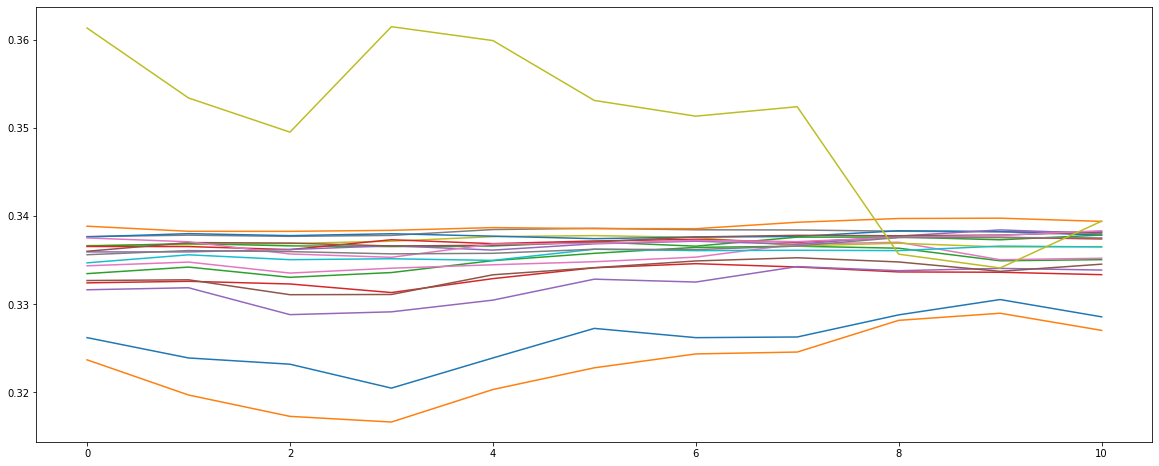

In [ ]:
from scipy.stats import pearsonr

matr_ = list()
matr_a= list()
subs = [1]
for s in subs:
  plt.figure(figsize=(20,8))
  # Cargar los datos almacenados de la entropia.
  datos = loadmat(load_path+f'Resultado2_music_Sujeto'+str(s)+'.mat')
  entropy_raw = np.mean(datos['H_raw'],axis=0)
  entropy_ica = np.mean(datos['H_ica'],axis=0)
  
  plt.plot(entropy_raw,label=f'Sujeto '+str(s))

In [ ]:
entropy_raw.shape

(11, 19)